- 나눔글꼴 설치 및 적용
    - 설치 후 런타임 재시작 필요

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,584 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120880 files and dire

- 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 서드파티 모듈 설치

In [ ]:
!pip install konlpy
!pip install mecab-python
!apt-get install -y openjdk-8-jdk
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 42.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 5.7 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1231 sha256=40c615adbe33b137248e8ef3d2716ea59f609c13579058c2f6d90474d6f6fb59
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java libatk-wrapper-java-jni libfontenc1
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libice-dev librsvg2-common
  libsm-dev libxkbfile1 libxt-dev libxtst6 libxxf86dga1 openjdk-8-jdk-h

# [1] 모듈 로드

In [ ]:
# OS
import os
import sys
import re
import warnings

# 분석
import pandas as pd
import numpy as np


# 시각화
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ML
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import LabelEncoder, MinMaxScaler



# Text
from konlpy.tag import Mecab
from konlpy.tag import Kkma
from konlpy.utils import pprint
from sklearn.feature_extraction.text import TfidfVectorizer


warnings.filterwarnings('ignore')
%matplotlib inline

# [2] 데이터 로드

- bank_info_df : 은행 기초재무정보주요경영지표
- dp_df : 은행/저축은행 예금상품 전체

In [ ]:
bank_info_df = pd.read_excel('/content/drive/MyDrive/ASAC/최종프로젝트_우리만/이한석/data/(저축)은행_기초재무정보주요경영지표.xlsx')
dp_df = pd.read_csv('/content/drive/MyDrive/ASAC/최종프로젝트_우리만/이한석/data/deposit_all.csv', encoding = 'utf-8')

In [ ]:
bank_info_df.shape, dp_df.shape

((100, 10), (740, 32))

In [ ]:
bank_info_df

,구분,총자산,총부채,자기자본,당기순이익,BIS비율,여신비율,ROA,NIM,유형
0,경남은행,49459933,45969835,3490097,179759,14.63,0.37,0.60,1.90,은행
1,광주은행,28586391,26404717,2181674,153747,15.69,0.45,0.88,2.89,은행
2,국민은행,506394830,471771786,34623044,2318601,18.45,0.25,0.60,1.82,은행
3,농협은행주식회사,392192577,369969859,22222718,1512360,18.67,0.29,0.46,1.98,은행
4,대구은행,68723045,63714954,5008091,286461,17.65,0.58,0.56,2.04,은행
...,...,...,...,...,...,...,...,...,...,...
95,한국투자저축은행,8611067,7403931,1207136,3129,16.30,4.35,1.04,NaN,저축은행
96,한성저축은행,397475,332131,65344,-1994,22.12,7.55,1.58,NaN,저축은행
97,한화저축은행,1754102,1579621,174481,4911,13.13,4.78,1.39,NaN,저축은행
98,흥국저축은행,516818,445217,71601,3529,16.97,3.13,1.74,NaN,저축은행


# [3] 문자열 전처리 및 통합

## 3-1. 데이터 로드

In [ ]:
dp6_df = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/data/금융감독원데이터/상품데이터_크롤링/예금/deposit_6.csv', encoding = 'utf-8', index_col='Unnamed: 0')

## 3-2. 칼럼 전처리

- 불필요 칼럼 삭제

In [ ]:
dp6_tmp = dp6_df.drop(['기간','비교 공시일','담당부서 및 연락처','세후이자(예시)'], axis = 1)

- 가입 대상 칼럼 전처리

In [ ]:
# 가입대상 칼럼과 가입대상.1 칼럼 전처리 (만약 두개의 칼럼이 다르다면 문자열을 붙여 가입대상_최종에 입력, 같다면 공백)
dp6_tmp['가입대상_최종'] = dp6_tmp.apply(lambda row: '' if row['가입대상'] == row['가입대상.1'] else row['가입대상'] + row['가입대상.1'], axis=1)

# '가입대상'과 '가입대상.1' 칼럼 삭제
dp6_tmp.drop(['가입대상', '가입대상.1'], axis=1, inplace=True)

# '가입대상_최종' 칼럼의 '없음' 제거
dp6_tmp['가입대상_최종'] = dp6_tmp['가입대상_최종'].apply(lambda x: x.replace('없음', ''))

# 비어있는 값 '제한없음'으로 채운다.
dp6_tmp['가입대상_최종'].fillna('제한없음', inplace=True)

In [ ]:
dp6_tmp['가입대상_최종'].unique()

array(['', '제한반려동물을 키우는 지점방문고객(개인)', '제한실명의 개인',
       '일부제한1954년 이전출생자 및 비과세종합저축가입대상자(만64세이상/국가유공자/국민기초생활보장법에의한수급자/장애인/독립유공자과그유족또는가족/고엽제후유증환자 및 5.18민주화운동부상자)',
       '제한스마트뱅크 가입고객', '제한모든고객', '제한개인(만19세이상)', '제한비대면 어플사용자',
       '제한인터넷 및 모바일뱅킹 사용자', '제한개인', '제한제한 ', '제한만 17세 이상 실명의 개인 및 개인사업자',
       '제한분당지점방문고객(타지점불가)', '제한개인(개인사업자 포함)', '제한인터넷뱅킹 및 스마트폰 뱅킹 신청자',
       '제한만 17세 이상의 실명의 개인', '제한실명의 개인\n(개인사업자 제외)', '제한실명의 개인(임의단체 제외)',
       '제한내·외국인 대상', '제한내국인 대상', '제한개인 및 개인사업자', '제한누구나가입가능',
       '제한만19세이상 내국인 개인고객, 본인 스마트폰 소지자, 신분증(주민등록증 또는 운전면허증)소지자, 최근 30일이내 전은행에서 입출금통장 개설내역이 없는 고객, 미국인납세자에 해당하지 않는 고객',
       '제한비거주 외국인 외 제한', '제한개인 및 법인(단,국가 지자체 및 금융기관 제외)', '제한-제한',
       '제한개인 및 법인고객', '제한개인고객', '제한', '제한인터넷뱅킹가입 대상',
       '제한토스뱅크 통장 또는 토스뱅크 서브 통장을 보유한 만 17세 이상 실명의 개인',
       '제한만19세이상 내국인 개인고객, 본인 스마트폰 소지자, 신분증(주민등록증 또는 운전면허증)소지자, 미국인 납세자에 해당하지 않는 고객',
       '제한인터넷뱅킹, 스마트폰뱅킹 전용', '제한-만19세이상의 개인', '제한만19세 이상 내국인(법인불가)',
       '제한만 19세 이상의 개인', '제한실명의 \n개인 및 \n개인

- 가입대상 추가 전처리

In [ ]:
word_list = ["없음","제한없음","누구나가입","모든고객", '실명의개인', "개인", "누구나가입가능"]
target_list = []
for i in range(len(dp6_tmp)):
    text = str(dp6_tmp.loc[i,'가입대상_최종'])
    text = re.sub('[^0-9a-zA-Zㄱ-ㅎ가-힣]', "", text)
    text = text.replace(" ","")
    Flag = False
    for w in word_list:
        if w == text:
            Flag = True
            break
    if Flag == True :
        target_list.append('제한없음')
    else:
        target_list.append(dp6_tmp.loc[i,'가입대상_최종'])

dp6_tmp['가입대상_최종'] = target_list

- 가입대상에서 나이 추출

In [ ]:
range_list = ['미만','이하','이상','초과']
p =re.compile('[0-9]+세')
p2 = re.compile('[0-9]+~[0-9]+세')
p3 = re.compile('[0-9]+~[0-9]+대')

In [ ]:
age_list = []
for i in range(len(dp6_tmp)):
    text_ori = dp6_tmp.loc[i,'가입대상_최종']
    text = text_ori.replace(" ","")

    if p3.search(text):
        s = p3.search(text).span()
        age_list.append(text[s[0]:s[1]])
    elif p2.search(text):
        s = p2.search(text).span()
        age_list.append(text[s[0]:s[1]])
    elif p.search(text):
        s = p.search(text).span()
        for r in range_list:
            range_w = ""
            if text[s[1]:s[1]+2] == r:
                range_w = text[s[1]:s[1]+2]
                break
        age_list.append(text[s[0]:s[1]] +" " +  range_w)
    else:
        age_list.append("나이제한없음")

In [ ]:
dp6_tmp['나이제한'] = age_list

- 우대조건 칼럼 전처리

In [ ]:
no_prime = ['없음', '해당없음', '-', '- 없음','해당사항없음', '- 없음', '우대조건 없음', '우대사항없음', '없음.', '* 해당사항없음', '-없음', '해당무']
dp6_tmp['우대조건'] = dp6_tmp['우대조건'].apply(lambda x: '없음' if x in no_prime else x)

- %문자열 수치형으로 변환

In [ ]:
dp6_tmp['세전이자율'] = dp6_tmp['세전이자율'].str.rstrip('%').astype('float')
dp6_tmp['세후이자율'] = dp6_tmp['세후이자율'].str.rstrip('%').astype('float')
dp6_tmp['최고우대금리'] = dp6_tmp['최고우대금리'].str.rstrip('%').astype('float')

- 실질 이자율 추가

In [ ]:
bir = 0.035 # 현재 기준금리 3.5% 반영

def month_df_real(interest,month):
    if not np.isnan(interest):
        a = 100 # 지급한 금액의 가치
        b = (interest) * (month/12.0) + 100  # 수익의 미래가치
        b = b / (1 + bir)**(month/12.0) # 만기후 수령액의 현재가치
        return ((b/a)**(12.0/month) - 1) * 100 # 1년 평균 이자율
    else:
        return 0

def month_df_complex_real(interest,month):
    if interest != np.nan:
        a =  100
        b =  100 * (1 + (interest * 0.01))** (month / 12.0)
        b = b / (1+ bir)**(month/12.0) # 만기후 수령액의 현재가치
        return ((b/a)**(12.0/month) - 1) * 100

    else:
        return 0

In [ ]:
real_interest = []
interest_period = []

for i in range(len(dp6_tmp)):
    if dp6_tmp.loc[i, '이자계산방식'] == '단리':  # 상품의 금리방식이 단리인 경우
        real_interest.append(month_df_real(dp6_tmp.loc[i, '세전이자율'], 6))
        interest_period.append(6)

    elif dp6_tmp.loc[i, '이자계산방식'] == '복리':  # 상품의 금리방식이 복리인 경우
        real_interest.append(month_df_complex_real(dp6_tmp.loc[i, '세전이자율'], 6))
        interest_period.append(6)

print(real_interest)

[0.9661835748792091, 1.0150966183574806, 0.9661835748792091, 1.0150966183574806, 0.9163285024154311, 0.8695652173913215, 0.8212560386472889, 0.8669625603864528, 0.8274785024154685, 0.782608695652165, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.7682669082125893, 0.7246376811594235, 0.7246376811594235, 0.7682669082125893, 0.6859903381642329, 0.7288021739130679, 0.7189371980676595, 0.6763285024154353, 0.7189371980676595, 0.6763285024154353, 0.7189371980676595, 

In [ ]:
dp6_tmp['실질이자율'] = real_interest

- 가입방법 칼럼 전처리
    - 전처리 방식
        - '인터넷,스마트폰', -> 인터넷스마트폰전용
        - '영업점', -> 영업점방문
        - '스마트폰', -> 인터넷스마트폰전용
        - '인터넷', -> 인터넷스마트폰전용
        - '영업점,인터넷', -> 인터넷스마트폰영업점
        - '인터넷,스마트폰,전화(텔레뱅킹)', -> 인터넷스마트폰텔레뱅킹
        - '영업점,인터넷,스마트폰', -> 인터넷스마트폰영업점
        - '영업점,스마트폰', -> 인터넷스마트폰영업점
        - '영업점,인터넷,스마트폰,전화(텔레뱅킹)' -> 인터넷스마트폰텔레뱅킹



In [ ]:
join_method_mapping = {
    '인터넷,스마트폰': '인터넷스마트폰전용',
    '영업점': '영업점방문',
    '스마트폰': '인터넷스마트폰전용',
    '스마트폰,전화(텔레뱅킹)' : '인터넷스마트폰텔레뱅킹',
    '인터넷': '인터넷스마트폰전용',
    '영업점,인터넷': '인터넷스마트폰영업점',
    '인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰텔레뱅킹',
    '영업점,인터넷,스마트폰': '인터넷스마트폰영업점',
    '영업점,스마트폰': '인터넷스마트폰영업점',
    '영업점,인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰영업점텔레뱅킹',
    '없음' : '기타',
    '모집인' : '기타'
}

# 딕셔너리에 따라 값들 변경
dp6_tmp['가입방법'] = dp6_tmp['가입방법'].map(join_method_mapping)

print(dp6_tmp['가입방법'].value_counts())

인터넷스마트폰전용         283
영업점방문             180
인터넷스마트폰영업점         27
인터넷스마트폰영업점텔레뱅킹      2
인터넷스마트폰텔레뱅킹         1
Name: 가입방법, dtype: int64


- 활용 가능한 문자열 모두 통합

In [ ]:
dp6_tmp['문자열통합'] = dp6_tmp['이자계산방식'] + ' ' + dp6_tmp['우대조건'] + ' ' + dp6_tmp['가입방법'] + ' ' + dp6_tmp['기타유의사항'] + ' ' + dp6_tmp['나이제한']

dp6_tmp['문자열통합'] = dp6_tmp['문자열통합'].str.replace('제한없음', '')
dp6_tmp['문자열통합'] = dp6_tmp['문자열통합'].str.replace('없음', '')

# [4] 수치형 전처리

- 최고_기본_diff :  최고우대금리 - 세전이자율

In [ ]:
dp6_tmp['최고_기본_diff'] = dp6_tmp['최고우대금리'] - dp6_tmp['세전이자율']

- 최고_기준_diff : 최고우대금리 - 현재금리(3.5)

In [ ]:
dp6_tmp['최고_기준_diff'] = dp6_tmp['최고우대금리'] - 3.5

- 은행 구분

In [ ]:
bank_list = list(set(list(dp6_tmp['금융회사'].unique())))

# 저축은행(jb)와 일반은행(gb)로 분할한다.
jb = []
gb = []
ob = ['주식회사 카카오뱅크',  '토스뱅크 주식회사', '주식회사 케이뱅크']

for bank in bank_list:
    if '저축' in bank:
        jb.append(bank)
    else:
        gb.append(bank)

gb_not_ob = [bank for bank in gb if bank not in ob]

# 결과 출력
print("저축은행 리스트:", jb)
print("일반은행 리스트:", gb)
print("온라인은행 리스트:", ob)
print("온라인은행 제외 일반은행:", gb_not_ob)

저축은행 리스트: ['유니온저축은행', '한성저축은행', '대아상호저축은행', '아산저축은행', '인성저축은행', 'OSB저축은행', '머스트삼일저축은행', '인천저축은행', '대백저축은행', '흥국저축은행', 'HB저축은행', '라온저축은행', '금화저축은행', '웰컴저축은행', 'JT친애저축은행', '삼호저축은행', '고려저축은행', '오성저축은행', '다올저축은행', '에스앤티저축은행', '디비저축은행', '안양저축은행', '더블저축은행', '신한저축은행', 'SBI저축은행', '페퍼저축은행', '대신저축은행', '스마트저축은행', '안국저축은행', '융창저축은행', '키움예스저축은행', '부림저축은행', '영진저축은행', '조은저축은행', '세람저축은행', '유안타저축은행', '애큐온저축은행', 'JT저축은행', 'KB저축은행', '스타저축은행', '동양저축은행', '국제저축은행', '동원제일저축은행', '스카이저축은행', '상상인저축은행', 'BNK저축은행', '더케이저축은행', '조흥저축은행', '우리금융저축은행', '키움저축은행', '바로저축은행', '모아저축은행', '한국투자저축은행', '솔브레인저축은행', 'DH저축은행', '참저축은행', '대한저축은행', '대명상호저축은행', 'CK저축은행', '오투저축은행', '상상인플러스저축은행', '대원저축은행', '엔에이치저축은행', '남양저축은행', '예가람저축은행', '푸른저축은행', '한화저축은행', '하나저축은행', '센트럴저축은행', 'IBK저축은행', 'OK저축은행', '민국저축은행', '청주저축은행', '평택상호저축은행', 'MS저축은행', '드림저축은행', '삼정저축은행', '진주저축은행', '우리저축은행']
일반은행 리스트: ['한국스탠다드차타드은행', '주식회사 카카오뱅크', '대구은행', '농협은행주식회사', '부산은행', '우리은행', '하나은행', '제주은행', '경남은행', '신한은행', '한국산업은행', '토스뱅크 주식회사', '국민은행', '주식회사 케이뱅크', '전북은행'

In [ ]:
def find_bank_type(df) :
    return df['금융회사'].apply(lambda x: '저축은행' if x in jb else ('온라인은행' if x in ob else ('일반은행' if x in gb_not_ob else None)))

In [ ]:
dp6_tmp['금융회사_종류'] =  find_bank_type(dp6_tmp)

In [ ]:
dp6_tmp

,금융회사,상품명,세전이자율,세후이자율,최고우대금리,이자계산방식,우대조건,가입방법,만기후 이자율,기타유의사항,가입대상_최종,나이제한,실질이자율,문자열통합,최고_기본_diff,최고_기준_diff,금융회사_종류
0,OSB저축은행,인터넷정기예금,4.50,3.81,4.5,복리,없음,인터넷스마트폰전용,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,,나이제한없음,0.966184,복리 인터넷스마트폰전용 -가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 ...,0.00,1.0,저축은행
1,OSB저축은행,인터넷정기예금,4.50,3.81,4.5,단리,없음,인터넷스마트폰전용,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,,나이제한없음,1.015097,단리 인터넷스마트폰전용 -가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 ...,0.00,1.0,저축은행
2,OSB저축은행,정기예금,4.50,3.81,4.5,복리,없음,영업점방문,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,,나이제한없음,0.966184,복리 영업점방문 -가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리...,0.00,1.0,저축은행
3,OSB저축은행,정기예금,4.50,3.81,4.5,단리,없음,영업점방문,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,,나이제한없음,1.015097,단리 영업점방문 -가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리...,0.00,1.0,저축은행
4,조은저축은행,정기예금(서울본점),4.40,3.72,4.4,단리,없음,영업점방문,- 1개월이내 해지: 만기시 동일상품 동일계약기간의 신규약정금리\n'- 1개월초과 ...,없음,,나이제한없음,0.916329,단리 영업점방문 나이,0.00,0.9,저축은행
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,엔에이치저축은행,비대면 정기예금,1.50,1.27,1.5,복리,없음,인터넷스마트폰전용,-1개월 이내: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리...,없음,,나이제한없음,-1.932367,복리 인터넷스마트폰전용 나이,0.00,-2.0,저축은행
489,엔에이치저축은행,정기예금,1.40,1.18,1.4,단리,없음,영업점방문,-1개월 이내: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리...,없음,,나이제한없음,-2.024251,단리 영업점방문 나이,0.00,-2.1,저축은행
490,엔에이치저축은행,정기예금,1.40,1.18,1.4,복리,없음,영업점방문,-1개월 이내: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리...,없음,,나이제한없음,-2.028986,복리 영업점방문 나이,0.00,-2.1,저축은행
491,머스트삼일저축은행,자유적립예금,1.00,0.85,1.0,단리,없음,영업점방문,- 만기후 1개월 이내 : 1.2%\n- 만기후 1개월 초과 : 연0.2%,없음,,나이제한없음,-2.413043,단리 영업점방문 나이,0.00,-2.5,저축은행


In [ ]:
dp6_tmp.columns

Index(['금융회사', '상품명', '세전이자율', '세후이자율', '최고우대금리', '이자계산방식', '우대조건', '가입방법',
       '만기후 이자율', '기타유의사항', '가입대상_최종', '나이제한', '실질이자율', '문자열통합', '최고_기본_diff',
       '최고_기준_diff', '금융회사_종류'],
      dtype='object')

# [5] 수치형칼럼으로 군집분석 실시

- '금융회사' : 사용 X
- '상품명' : 사용 X
- '세전이자율'
- '최고우대금리'
-'이자계산방식' : 라벨인코딩
-'실질이자율'
-'최고_기본_diff'
-'최고_기준_diff'
- '금융회사_종류' : 라벨인코딩


## 5.1 전처리

In [ ]:
dp6_num_tmp = dp6_tmp[['세전이자율','최고우대금리','이자계산방식','실질이자율','최고_기본_diff','최고_기준_diff','금융회사_종류']]

In [ ]:
dp6_num_tmp

,세전이자율,최고우대금리,이자계산방식,실질이자율,최고_기본_diff,최고_기준_diff,금융회사_종류
0,4.50,4.5,복리,0.966184,0.00,1.0,저축은행
1,4.50,4.5,단리,1.015097,0.00,1.0,저축은행
2,4.50,4.5,복리,0.966184,0.00,1.0,저축은행
3,4.50,4.5,단리,1.015097,0.00,1.0,저축은행
4,4.40,4.4,단리,0.916329,0.00,0.9,저축은행
...,...,...,...,...,...,...,...
488,1.50,1.5,복리,-1.932367,0.00,-2.0,저축은행
489,1.40,1.4,단리,-2.024251,0.00,-2.1,저축은행
490,1.40,1.4,복리,-2.028986,0.00,-2.1,저축은행
491,1.00,1.0,단리,-2.413043,0.00,-2.5,저축은행


- 라벨인코딩

In [ ]:
label_cols = ['이자계산방식', '금융회사_종류']
label_mapping = {}

label_encoder = LabelEncoder()
for col in label_cols:
    dp6_num_tmp[col] = label_encoder.fit_transform(dp6_num_tmp[col])
    # 변환 전, 후의 매핑 정보 저장
    label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [ ]:
# 변환된 값 확인
print("Label Encoding Mapping:")
for col, mapping in label_mapping.items():
    print(f"{col} 변환 전: {mapping}")
    print(f"{col} 변환 후: {dp6_num_tmp[col].unique()}")
    print()

Label Encoding Mapping:
이자계산방식 변환 전: {'단리': 0, '복리': 1}
이자계산방식 변환 후: [1 0]

금융회사_종류 변환 전: {'온라인은행': 0, '일반은행': 1, '저축은행': 2}
금융회사_종류 변환 후: [2 1 0]



## 5.2 군집분석

### K-means 분석

- 데이터 확인

In [ ]:
dp6_num_tmp_km = dp6_num_tmp.copy()

- Elbow 그림으로 최적 군집 갯수 확인, 실루엣 score 확인

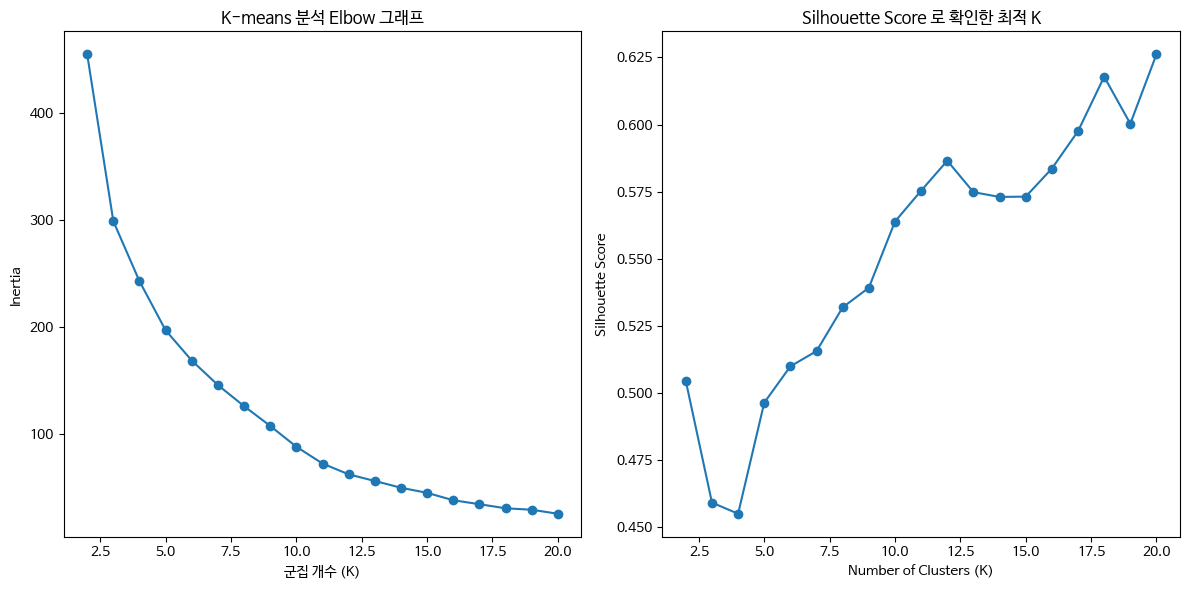

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dp6_num_tmp_km)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(dp6_num_tmp_km, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

- 최적 K로 군집분석

In [ ]:
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(dp6_num_tmp_km)

# 클러스터 결과를 데이터프레임에 추가
dp6_num_tmp_km['cluster_num'] = kmeans.labels_

- 군집 분포 확인

In [ ]:
dp6_num_tmp_km['상품명'] = dp6_tmp['상품명']
dp6_num_tmp_km['은행명'] = dp6_tmp['금융회사']

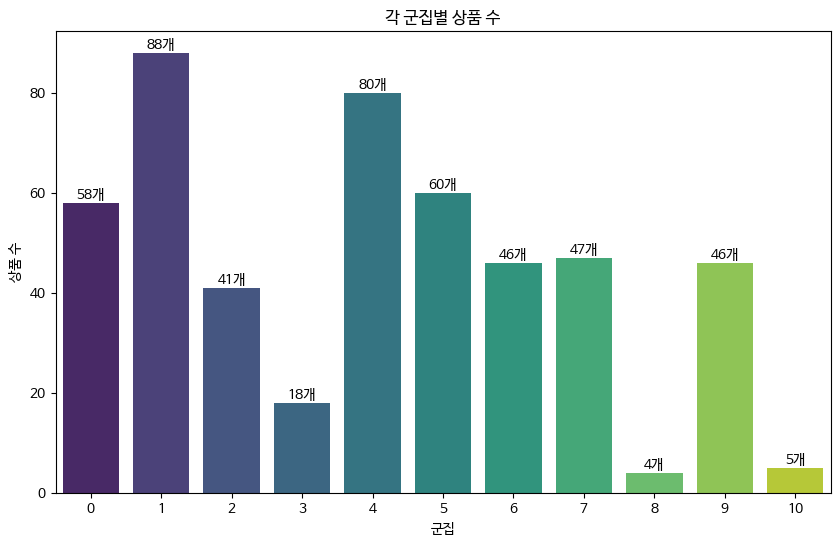

In [ ]:
df_result_km = dp6_num_tmp_km.groupby(['cluster_num']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='상품명', data= df_result_km, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

- 군집별 특징 파악

In [ ]:
dp6_num_tmp_km.columns

Index(['세전이자율', '최고우대금리', '이자계산방식', '실질이자율', '최고_기본_diff', '최고_기준_diff',
       '금융회사_종류', 'cluster_num', '상품명', '은행명'],
      dtype='object')

In [ ]:
dp6_num_mean_result = dp6_num_tmp_km.groupby(['cluster_num']).mean()[['세전이자율','최고우대금리','실질이자율','최고_기본_diff','최고_기준_diff']].reset_index()

In [ ]:
def plot_cluster_comparison(df, feature):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='cluster_num', y=feature, data=df, palette='Paired')

    for p in ax.patches:
         ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.title(f'군집별 평균 {feature} 비교')

    plt.xlabel('군집')
    plt.ylabel(feature)

    plt.show()

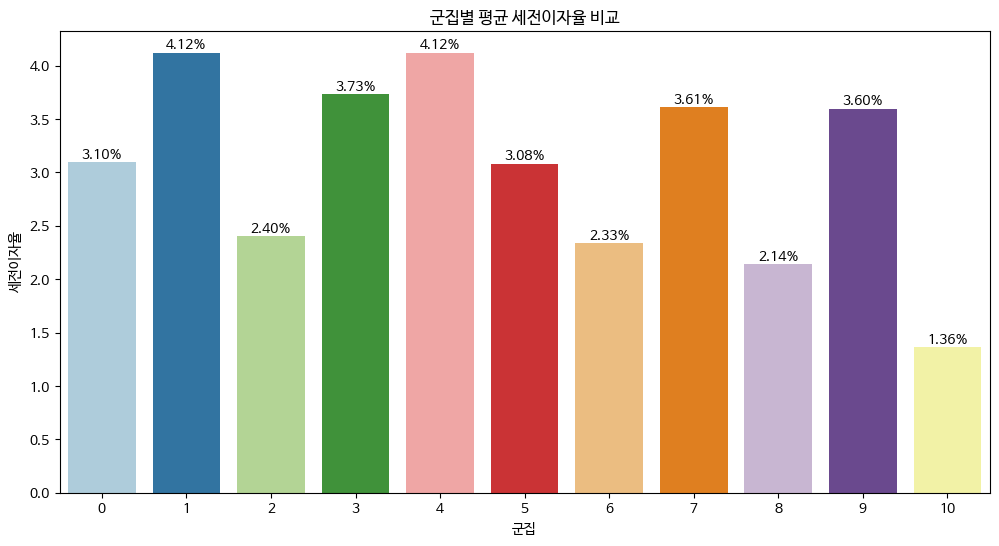

In [ ]:
plot_cluster_comparison(dp6_num_mean_result, '세전이자율')

* 군집별 특징 분석 (세전 이자율)
<br/>
(+) 구분 기준 : (매우 높다, 높다, 보통, 낮다, 매우 낮다)
<br/>

- 0번 군집 : 기본 이자율 보통 /
- 1번 군집 : 기본 이자율 매우 높음 /
- 2번 군집 : 기본 이자율 낮음 /
- 3번 군집 : 기본 이자율 높음 /
- 4번 군집 : 기본 이자율 매우 높음 /
- 5번 군집 : 기본 이자율 보통 /
- 6번 군집 : 기본 이자율 낮음 /
- 7번 군집 : 기본 이자율 높음 /
- 8번 군집 : 기본 이자율 매우 낮음 /
- 9번 군집 : 기본 이자율 높음 /
- 10번 군집 : 기본 이자율 매우 낮음 /

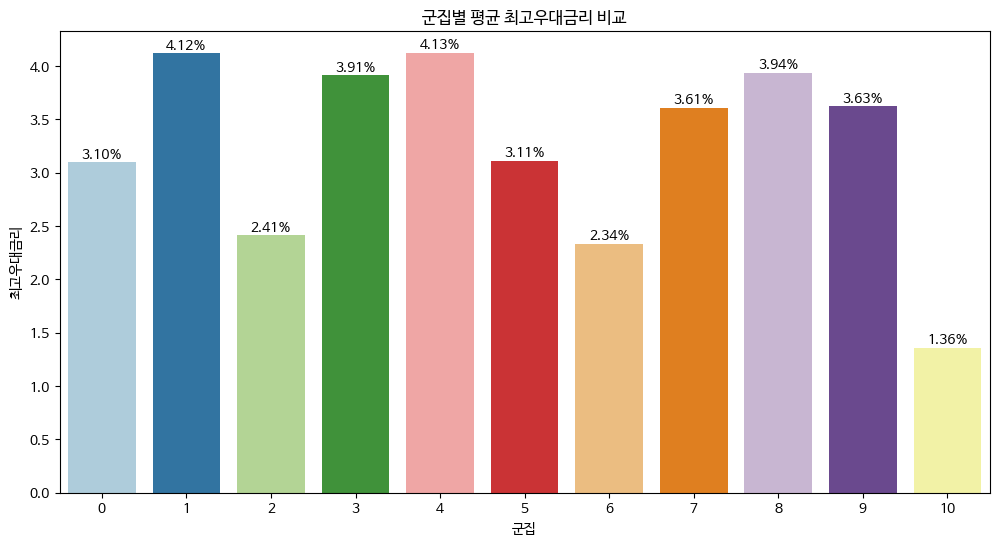

In [ ]:
plot_cluster_comparison(dp6_num_mean_result, '최고우대금리')

* 군집별 특징 분석 (세전 이자율, 최고우대금리)
<br/>
(+) 구분 기준 : (매우 높다, 높다, 보통, 낮다, 매우 낮다)
<br/>

- 0번 군집 : 기본 이자율 보통 / 최고(우대)금리 보통
- 1번 군집 : 기본 이자율 매우 높음 / 최고(우대)금리 매우 높음
- 2번 군집 : 기본 이자율 낮음 / 최고(우대)금리 낮음
- 3번 군집 : 기본 이자율 높음 / 최고(우대)금리 높음
- 4번 군집 : 기본 이자율 매우 높음 / 최고(우대)금리 매우 높음
- 5번 군집 : 기본 이자율 보통 / 최고(우대)금리 보통
- 6번 군집 : 기본 이자율 낮음 / 최고(우대)금리 낮음
- 7번 군집 : 기본 이자율 높음 / 최고(우대)금리 높음
- 8번 군집 : 기본 이자율 매우 낮음 / 최고(우대)금리 높음
- 9번 군집 : 기본 이자율 높음 / 최고(우대)금리 높음
- 10번 군집 : 기본 이자율 매우 낮음 / 최고(우대)금리 매우 낮음

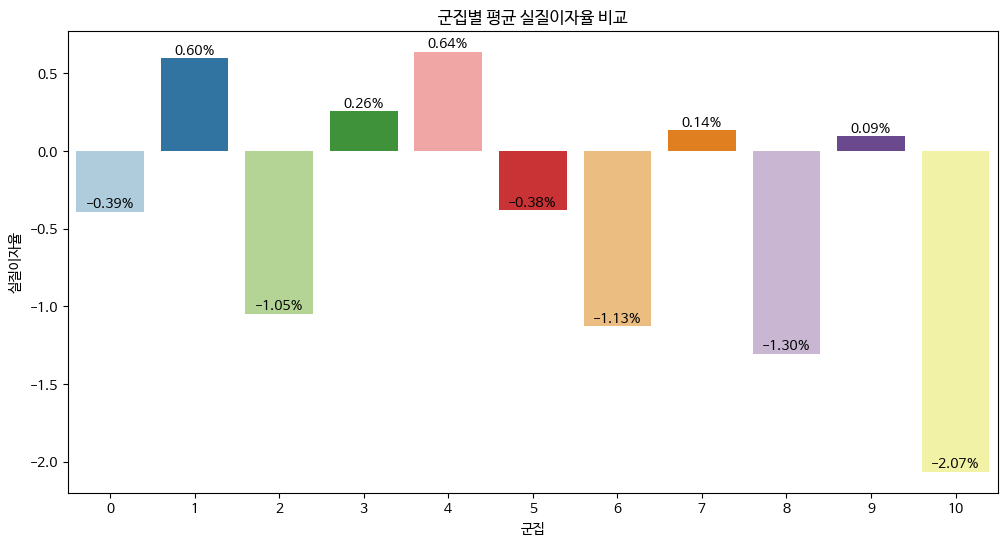

In [ ]:
plot_cluster_comparison(dp6_num_mean_result, '실질이자율')

* 군집별 특징 분석 (세전 이자율, 최고우대금리)
<br/>
(+) 구분 기준 : (매우 높다, 높다, 보통, 낮다, 매우 낮다)
<br/>

- 기본 이자율로 계산했기 떄문에, 기본 이자율과 유사한 패턴이다.

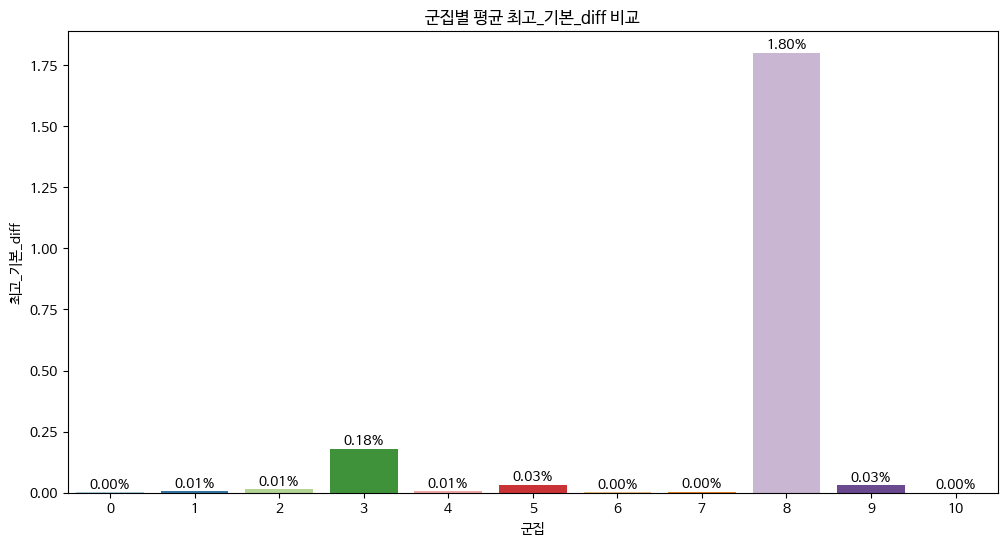

In [ ]:
plot_cluster_comparison(dp6_num_mean_result, '최고_기본_diff')

- 8번 군집은 최고금리와 기본 금리의 편차가 가장 크다. (우대금리 존재)
- 그 다음은 3번 군집정도이다.

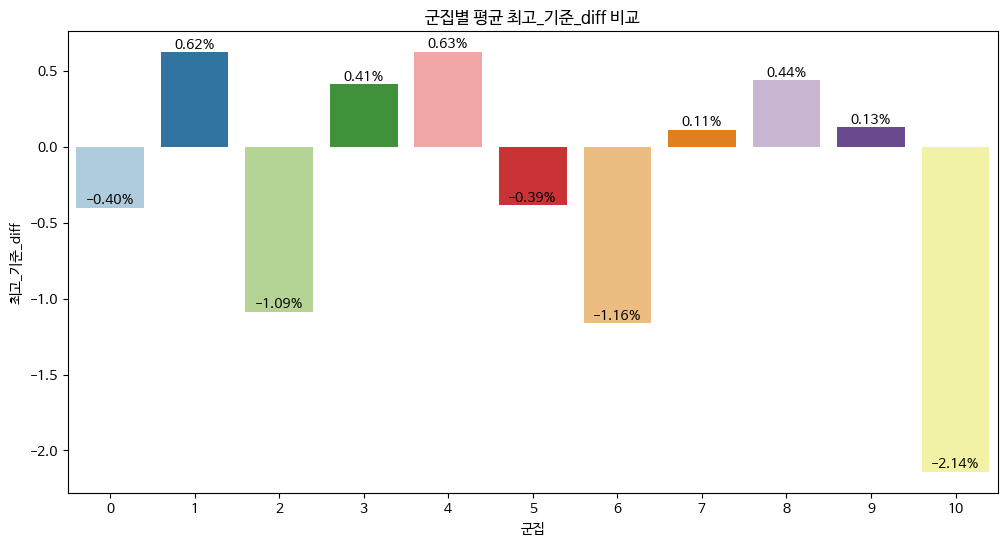

In [ ]:
plot_cluster_comparison(dp6_num_mean_result, '최고_기준_diff')

- 기준 금리와 비교해봐도 최고 금리와 비슷한 양상이다.

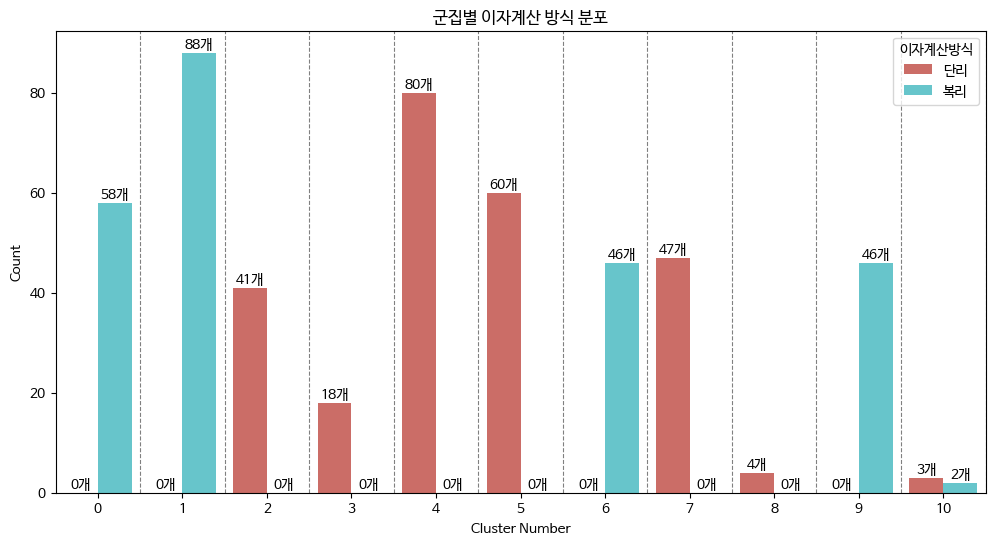

In [ ]:
dp6_num_tmp_km['이자계산방식'] = dp6_num_tmp_km['이자계산방식']

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='cluster_num', hue='이자계산방식', data=dp6_num_tmp_km, palette='hls')

# annotations 추가
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='이자계산방식', loc='upper right', labels=['단리', '복리'])

# 점선 추가
for i in range(len(ax.patches) // 2):
    plt.axvline(x=(1 * i + 0.5), color='gray', linestyle='--', linewidth=0.8)

plt.title('군집별 이자계산 방식 분포')
plt.xlabel('Cluster Number')
plt.ylabel('Count')
plt.show()

* 군집별 특징 분석
<br/>
(+) 구분 기준 : (매우 높다, 높다, 보통, 낮다, 매우 낮다)
<br/>

- 0번 군집 : 기본 이자율 보통 / 최고(우대)금리 보통 / 복리 상품
- 1번 군집 : 기본 이자율 매우 높음 / 최고(우대)금리 매우 높음 / 복리 상품
- 2번 군집 : 기본 이자율 낮음 / 최고(우대)금리 낮음 / 단리 상품
- 3번 군집 : 기본 이자율 높음 / 최고(우대)금리 높음 / 단리 상품
- 4번 군집 : 기본 이자율 매우 높음 / 최고(우대)금리 매우 높음 / 단리 상품
- 5번 군집 : 기본 이자율 보통 / 최고(우대)금리 보통 / 단리 상품
- 6번 군집 : 기본 이자율 낮음 / 최고(우대)금리 낮음 / 복리 상품
- 7번 군집 : 기본 이자율 높음 / 최고(우대)금리 높음 / 단리 상품
- 8번 군집 : 기본 이자율 매우 낮음 / 최고(우대)금리 높음 [최고 금리와 기본 이자율 편차가 크다] / 단리 상품
- 9번 군집 : 기본 이자율 높음 / 최고(우대)금리 높음 / 복리 상품
- 10번 군집 : 기본 이자율 매우 낮음 / 최고(우대)금리 매우 낮음 / 단복리 혼합

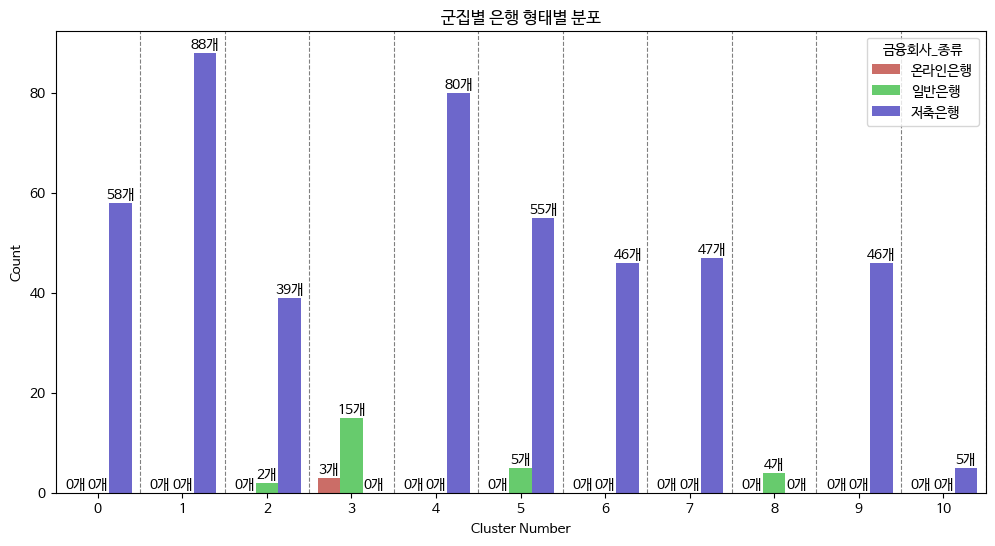

In [ ]:
dp6_num_tmp_km['금융회사_종류'] = dp6_num_tmp_km['금융회사_종류']

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='cluster_num', hue='금융회사_종류', data=dp6_num_tmp_km, palette='hls')

# annotations 추가
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='금융회사_종류', loc='upper right', labels=['온라인은행', '일반은행','저축은행'])

# 점선 추가
for i in range(len(ax.patches) // 3):
    plt.axvline(x=(1 * i + 0.5), color='gray', linestyle='--', linewidth=0.8)

plt.title('군집별 은행 형태별 분포')
plt.xlabel('Cluster Number')
plt.ylabel('Count')
plt.show()

* 군집별 특징 분석 (세전 이자율, 최고우대금리)
<br/>
(+) 구분 기준 : (매우 높다, 높다, 보통, 낮다, 매우 낮다)
<br/>

- 0번 군집 : 기본 이자율 보통 / 최고(우대)금리 보통 / 복리 상품 / 저축 은행
- 1번 군집 : 기본 이자율 매우 높음 / 최고(우대)금리 매우 높음 / 복리 상품 / 저축 은행
- 2번 군집 : 기본 이자율 낮음 / 최고(우대)금리 낮음 / 단리 상품 / 저축은행, 일부 일반 은행
- 3번 군집 : 기본 이자율 높음 / 최고(우대)금리 높음 / 단리 상품 / 온라인 은행 전체 + 일반은행
- 4번 군집 : 기본 이자율 매우 높음 / 최고(우대)금리 매우 높음 / 단리 상품 / 저축은행
- 5번 군집 : 기본 이자율 보통 / 최고(우대)금리 보통 / 단리 상품 / 저축은행 + 일부 일반은행
- 6번 군집 : 기본 이자율 낮음 / 최고(우대)금리 낮음 / 복리 상품 / 저축 은행
- 7번 군집 : 기본 이자율 높음 / 최고(우대)금리 높음 / 단리 상품 / 저축은행
- 8번 군집 : 기본 이자율 매우 낮음 / 최고(우대)금리 높음 [최고 금리와 기본 이자율 편차가 크다] / 단리 상품 / 일반 은행
- 9번 군집 : 기본 이자율 높음 / 최고(우대)금리 높음 / 복리 상품 / 저축 은행
- 10번 군집 : 기본 이자율 매우 낮음 / 최고(우대)금리 매우 낮음 / 단복리 혼합 / 저축은행

### Mean-shifht 방식

In [ ]:
dp6_num_ms = dp6_num_tmp.copy()
dp6_num_ms

,세전이자율,최고우대금리,이자계산방식,실질이자율,최고_기본_diff,최고_기준_diff,금융회사_종류
0,4.50,4.5,1,0.966184,0.00,1.0,2
1,4.50,4.5,0,1.015097,0.00,1.0,2
2,4.50,4.5,1,0.966184,0.00,1.0,2
3,4.50,4.5,0,1.015097,0.00,1.0,2
4,4.40,4.4,0,0.916329,0.00,0.9,2
...,...,...,...,...,...,...,...
488,1.50,1.5,1,-1.932367,0.00,-2.0,2
489,1.40,1.4,0,-2.024251,0.00,-2.1,2
490,1.40,1.4,1,-2.028986,0.00,-2.1,2
491,1.00,1.0,0,-2.413043,0.00,-2.5,2


In [ ]:
# 최적 bandwidth 추정
bandwidth = estimate_bandwidth(dp6_num_ms, quantile=0.2, n_samples=500)

print(bandwidth)

1.0329171836286717


In [ ]:
meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)

In [ ]:
meanshift.fit(dp6_num_ms)

cluster_centers = meanshift.cluster_centers_

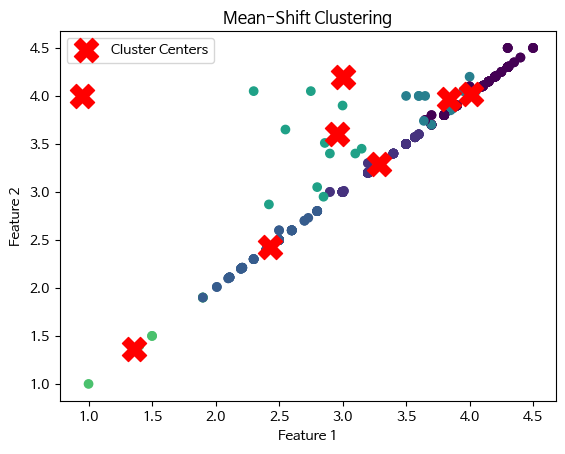

In [ ]:
plt.scatter(dp6_num_ms.iloc[:, 0], dp6_num_ms.iloc[:, 1], c=meanshift.labels_, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='X', s=300, label='Cluster Centers')
plt.title('Mean-Shift Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

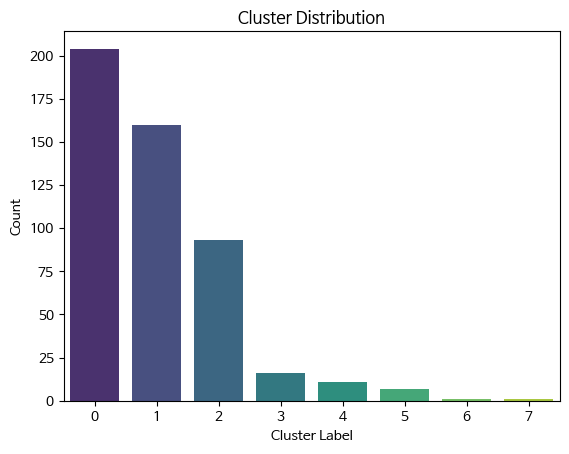

In [ ]:
# Assuming 'labels' contains the cluster labels assigned by Mean-shift
labels = meanshift.labels_

# Countplot of cluster distribution
sns.countplot(x=labels, palette='viridis')
plt.title('Cluster Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

In [ ]:
dp6_num_ms['cluster_label'] = meanshift.labels_

In [ ]:
dp6_num_ms.groupby('cluster_label').mean()

,세전이자율,최고우대금리,이자계산방식,실질이자율,최고_기본_diff,최고_기준_diff,금융회사_종류
cluster_label,,,,,,,
0,4.056667,4.063529,0.519608,0.556960,0.006863,0.563529,2.000000
1,3.257875,3.260375,0.500000,-0.221034,0.002500,-0.239625,2.000000
2,2.416667,2.418817,0.548387,-1.040052,0.002151,-1.081183,1.989247
3,3.814375,3.942500,0.000000,0.338994,0.128125,0.442500,0.812500
4,2.789091,3.480000,0.000000,-0.667919,0.690909,-0.020000,1.000000
5,1.514286,1.514286,0.285714,-1.914275,0.000000,-1.985714,2.000000
6,3.000000,4.200000,1.000000,-0.483092,1.200000,0.700000,2.000000
7,0.950000,4.000000,0.000000,-2.461588,3.050000,0.500000,1.000000


# [6] 문자열 + 수치형 칼럼으로 군집분석

- 문자열과 수치형을 합치면 설명력이 급격하게 떨어진다.

In [ ]:
dp6_num_tmp['문자열통합'] = dp6_tmp['우대조건'] + ' ' + dp6_tmp['가입방법'] + ' ' + dp6_tmp['기타유의사항'] + ' ' + dp6_tmp['나이제한']

dp6_num_tmp['문자열통합'] = dp6_num_tmp['문자열통합'].str.replace('제한없음', '')
dp6_num_tmp['문자열통합'] = dp6_num_tmp['문자열통합'].str.replace('없음', '')

In [ ]:
# Konlpy의 Kkma를 이용하여 명사 추출
#kkma = Kkma()
mecab = Mecab()
stopwords = []
tokenized_texts = []
texts = dp6_num_tmp['문자열통합']

for text in texts:
    nouns = [noun for noun in mecab.nouns(text) if noun not in stopwords]
    tokenized_texts.append(' '.join(nouns))

In [ ]:
tokenized_texts

['인터넷 스마트폰 전용 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령 나이',
 '인터넷 스마트폰 전용 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령 나이',
 '영업 점 방문 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령 나이',
 '영업 점 방문 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령 나이',
 '영업 점 방문 나이',
 '영업 점 방문 나이',
 '영업 점 방문 나이',
 '영업 점 방문 나이',
 '영업 점 방문 가입 한도 나이',
 '영업 점 방문 가입 한도 나이',
 '영업 점 방문 변동 금리 상품 가입 기간 개월 가입 후 매 개월 회전 주기 단위 약정 율 변동 중도 지이 개월 미만 신규 일 보통 예금 금리 개월 미만 약정 율 나이',
 '영업 점 방문 변동 금리 상품 가입 기간 개월 가입 후 매 개월 회전 주기 단위 약정 율 변동 중도 지이 개월 미만 신규 일 보통 예금 금리 개월 미만 약정 율 나이',
 '인터넷 스마트폰 전용 변동 금리 상품 가입 기간 개월 가입 후 매 개월 회전 주기 단위 약정 율 변동 중도 지이 개월 미만 신규 일 보통 예금 금리 개월 미만 약정 율 나이',
 '인터넷 스마트폰 전용 변동 금리 상품 가입 기간 개월 가입 후 매 개월 회전 주기 단위 약정 율 변동 중도 지이 개월 미만 신규 일 보통 예금 금리 개월 미만 약정 율 나이',
 '영업 점 방문 최소 입금액 만 원 이상 나이',
 '인터넷 스마트폰 전용 최소 입금액 만 원 이상 나이',
 '영업 점 방문 최소 입금액 만 원 이상 나이',
 '인터넷 스마트폰 전용 최소 입금액 만 원 이상 나이',
 '인터넷 스마트폰 전용 가입 채널 제한 스마트폰 전용 상품 도금액 초과 시 조기 소진 수 나이',
 '인터넷 스마트폰 전용 가입 채널 제한 스마트폰 전용 상품 도금액 초과 시 조기 소진 수 나이',
 '인터넷 스마트폰 전용 가입 채널 제한 인터넷 스마트폰 전용 상품 도금액 초과 시 조기 소진 수 나이'

- TF-IDF 벡터화


In [ ]:
vectorizer = TfidfVectorizer(max_features=50)
tf_idf_data = vectorizer.fit_transform(tokenized_texts)

In [ ]:
tf_idf_data.toarray(), tf_idf_data.toarray().shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (493, 50))

- 수치형 칼럼과 TF-IDF 결과 병합

In [ ]:
feature_names = vectorizer.get_feature_names_out()

tf_idf_df = pd.DataFrame(tf_idf_data.toarray(), columns=feature_names)
tf_idf_df.shape

(493, 50)

In [ ]:
dp6_num_str = pd.concat([dp6_num_tmp.iloc[:,:-1], tf_idf_df], axis = 1)

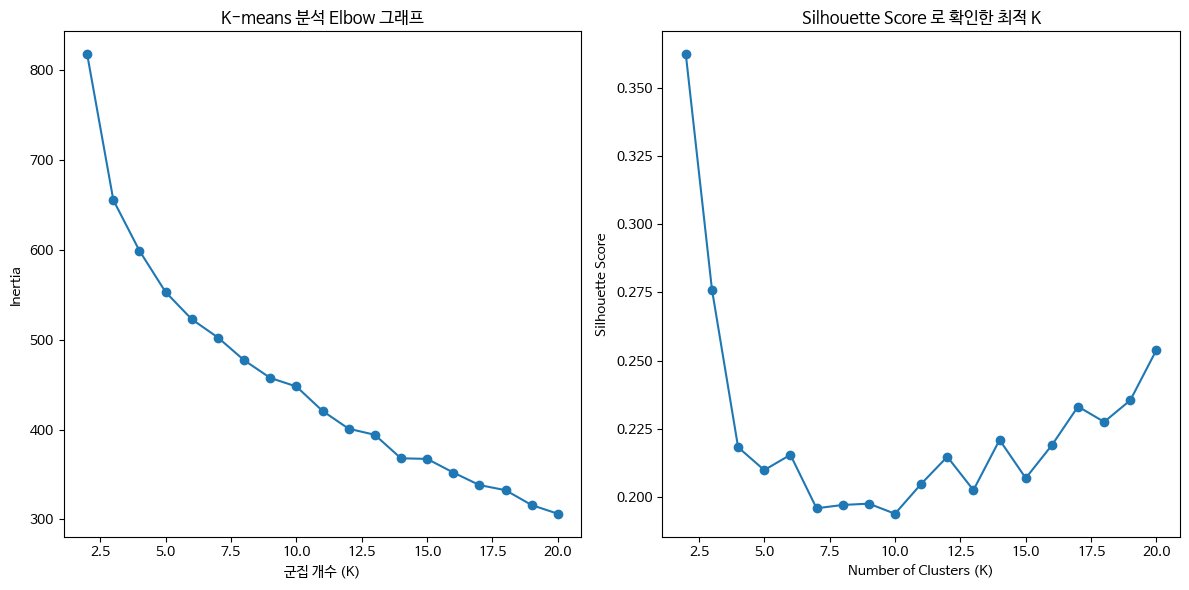

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dp6_num_str)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(dp6_num_str, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

- 최적 K로 군집분석

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(dp6_num_str)

# 클러스터 결과를 데이터프레임에 추가
dp6_num_str['cluster_num'] = kmeans.labels_

- 군집 분포 확인

In [ ]:
dp6_num_str['상품명'] = dp6_tmp['상품명']
dp6_num_str['은행명'] = dp6_tmp['금융회사']

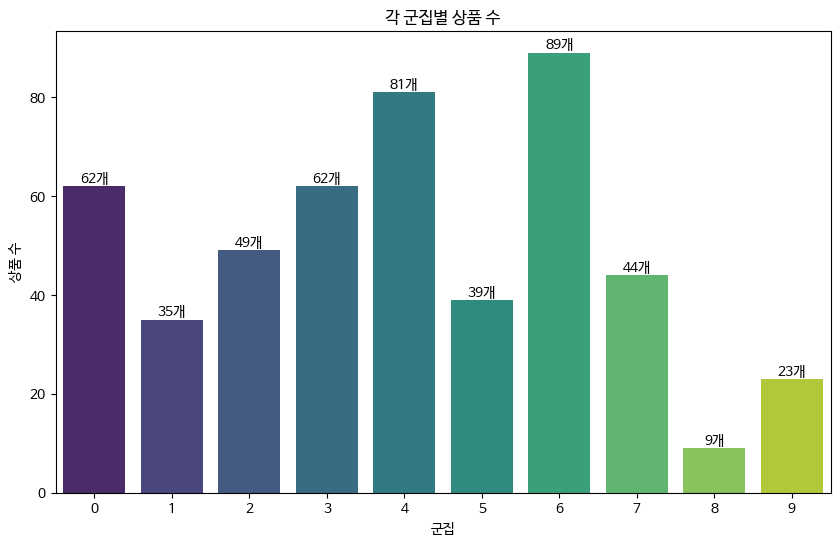

In [ ]:
df_result_km = dp6_num_str.groupby(['cluster_num']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='상품명', data= df_result_km, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

In [ ]:
cluster_centers = kmeans.cluster_centers_

# 각 군집의 중심에서 가장 가까운 단어 20개씩 추출
top_words_per_cluster = []
for center in cluster_centers:
    # 각 군집의 중심에서 가까운 10개 단어씩 가져오기
    top_word_indices = center.argsort()[-10:][::-1]

    # 해당 인덱스에 해당하는 단어들을 리스트에 추가
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_word_indices]
    top_words_per_cluster.append(top_words)

# 각 군집의 중심에서 가장 가까운 단어 출력
for i, top_words in enumerate(top_words_per_cluster):
    print(f"Cluster {i+1}: {', '.join(top_words)}")

Cluster 1: 가맹점, 가능, 간별, 입출금, 정상, 실예, 대구은행, 경우, 인당, 예금자
Cluster 2: 가능, 가맹점, 간별, 가지, 가정, 변경, 온라인, 가입, 대구은행, 개월
Cluster 3: 가맹점, 가능, 간별, 가입, 경우, 백만, 정상, 대구은행, 인당, 입출금
Cluster 4: 가맹점, 가능, 간별, 가입, 입출금, 정상, 실예, 대구은행, 경우, 인당
Cluster 5: 가맹점, 가능, 간별, 가정, 가지, 정상, 실예, 입출금, 대구은행, 경우
Cluster 6: 가능, 가맹점, 간별, 변경, 온라인, 가입, 대구은행, 입출금, 실예, 인당
Cluster 7: 가맹점, 가능, 간별, 가입, 가지, 가정, 정상, 실예, 입출금, 대구은행
Cluster 8: 가맹점, 가능, 간별, 경우, 백만, 대구은행, 정상, 입출금, 인당, 온라인
Cluster 9: 간별, 가맹점, 가능, 가입, 변경, 대구은행, 온라인, 정상, 실예, 입출금
Cluster 10: 가맹점, 가능, 간별, 가족, 가지, 개월, 인당, 경우, 보너스, 나머지


In [ ]:
dp6_num_str['tokenized_texts'] = tokenized_texts
dp6_num_str.tokenized_texts

0      인터넷 스마트폰 전용 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령 나이
1      인터넷 스마트폰 전용 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령 나이
2          영업 점 방문 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령 나이
3          영업 점 방문 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령 나이
4                                             영업 점 방문 나이
                             ...                        
488                                       인터넷 스마트폰 전용 나이
489                                           영업 점 방문 나이
490                                           영업 점 방문 나이
491                                           영업 점 방문 나이
492                           인터넷 스마트폰 전용 입금액 백만 원 이상 나이
Name: tokenized_texts, Length: 493, dtype: object

In [ ]:
def cutthe_text(strs):
    if isinstance(strs, str) and len(strs) > 30:
        return strs[:30]
    elif pd.isna(strs):
        return 'NaN'
    else:
        return strs

def decode_txt(strs):
    try:
        return strs.decode('utf-8')
    except:
        return strs

for i in range(12):
    print("cluster {}".format(i), '\n', tabulate(dp6_num_str[dp6_num_str.cluster_num == i].applymap(decode_txt)[['상품명', '은행명', 'tokenized_texts']].applymap(cutthe_text).head(20),
                                                  headers='keys', tablefmt='psql'))

cluster 0 
 +-----+---------------------------+------------------+------------------------------------------------------+
|     | 상품명                    | 은행명           | tokenized_texts                                      |
|-----+---------------------------+------------------+------------------------------------------------------|
| 220 | 비대면-정기예금           | 안양저축은행     | 인터넷 스마트폰 전용 중도 지이 개월 미만 계약 일 보  |
| 221 | 정기예금                  | 안양저축은행     | 가입 기간 개월 이상 계약 금액 억 이상 개인 법인 단   |
| 224 | 정기예금(부산,울산,창원)  | 진주저축은행     | 영업 점 방문 세 이상 과세 종합 저축 만 원 가능 나    |
| 226 | 정기예금(진주)            | 진주저축은행     | 영업 점 방문 세 이상 과세 종합 저축 만 원 가능 나    |
| 228 | 정기예금(통영)            | 진주저축은행     | 영업 점 방문 세 이상 과세 종합 저축 만 원 가능 나    |
| 229 | 지니뱅크-정기예금(비대면) | 진주저축은행     | 인터넷 스마트폰 전용 세 이상 과세 종합 저축 만 원    |
| 232 | E-정기예금(비대면)        | 진주저축은행     | 인터넷 스마트폰 전용 세 이상 과세 종합 저축 만 원    |
| 234 | M-정기예금(비대면)        | 진주저축은행     | 인터넷 스마트폰 전용 세 이상 과세 종합 저축 만 원    |
| 236 | E-플러스 정기예금         | 대명상호저축은행 | 인터넷 스마트폰

In [ ]:
dp6_num_str.groupby(['cluster_num']).mean().iloc[:,:7]

,세전이자율,최고우대금리,이자계산방식,실질이자율,최고_기본_diff,최고_기준_diff,금융회사_종류
cluster_num,,,,,,,
0,3.267258,3.276129,0.000000,-0.198966,0.008871,-0.223871,1.967742
1,4.141143,4.141143,0.485714,0.640837,0.000000,0.641143,2.000000
2,2.398571,2.400612,1.000000,-1.064182,0.002041,-1.099388,2.000000
3,3.273226,3.295806,1.000000,-0.219106,0.022581,-0.204194,2.000000
4,4.035926,4.044568,0.000000,0.557240,0.008642,0.544568,1.987654
5,3.189744,3.189744,0.487179,-0.287025,0.000000,-0.310256,2.000000
6,4.043933,4.051798,1.000000,0.525539,0.007865,0.551798,2.000000
7,2.427045,2.508864,0.000000,-1.022251,0.081818,-0.991136,1.931818
8,1.600000,1.600000,0.444444,-1.832413,0.000000,-1.900000,2.000000
